In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Preprocessing

In [2]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Merge datasets
merged_data = pd.merge(transactions, customers, on='CustomerID')
merged_data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [4]:
# Aggregate transaction data per customer
customer_data = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total transaction value
    'Quantity': 'sum',    # Total quantity purchased
    'TransactionID': 'count'  # Transaction frequency
}).reset_index()

# Add profile data (Region)
customer_data = pd.merge(customer_data, customers[['CustomerID', 'Region']], on='CustomerID')

# Encode categorical variables
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop('CustomerID', axis=1))

# Print preprocessed data
print(pd.DataFrame(scaled_data).head())

          0         1         2         3         4         5
0 -0.061701 -0.122033 -0.011458 -0.579284 -0.548319  1.540416
1 -0.877744 -0.448000 -0.467494 -0.579284 -0.548319 -0.649175
2 -0.405857  0.203934 -0.467494 -0.579284 -0.548319  1.540416
3  1.032547  1.670787  1.356650 -0.579284 -0.548319  1.540416
4 -0.783929 -0.936951 -0.923530 -0.579284 -0.548319 -0.649175


Clustering and DB Index Calculation


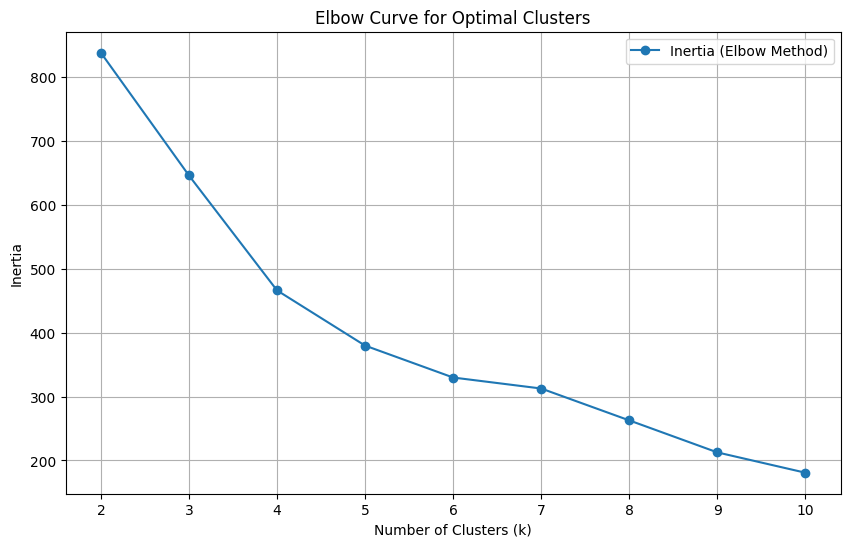

In [7]:
# Use the Elbow Method to find the optimal number of clusters
inertia = []  # To store inertia for each k
db_indices = []  # To store DB Index for each k
k_range = range(2, 11)  # Cluster numbers between 2 and 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    db_indices.append(davies_bouldin_score(scaled_data, kmeans.labels_))

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', label='Inertia (Elbow Method)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for Optimal Clusters')
plt.grid(True)
plt.legend()
plt.show()

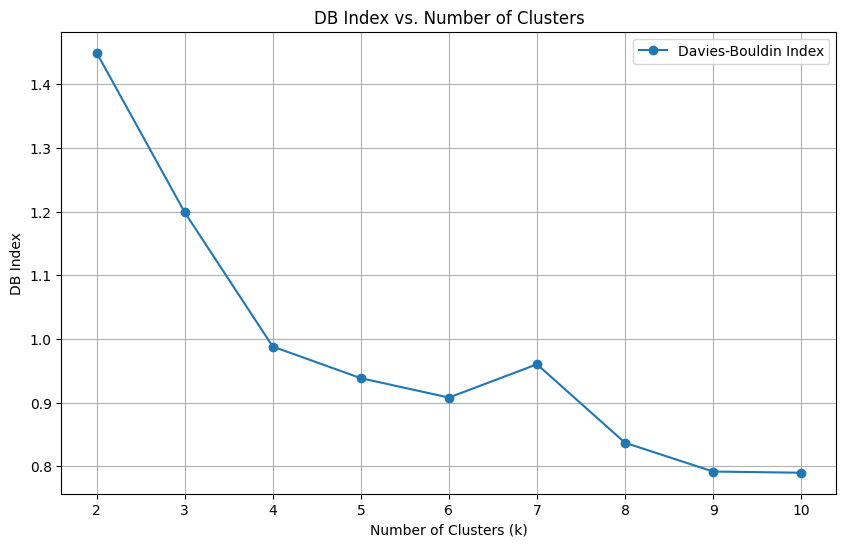

In [8]:
# Plot DB Index for each k
plt.figure(figsize=(10, 6))
plt.plot(k_range, db_indices, marker='o', label='Davies-Bouldin Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
plt.title('DB Index vs. Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Choose the optimal number of clusters based on the Elbow point or minimum DB Index
optimal_k = 6
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans_optimal.fit_predict(scaled_data)

# Calculate DB Index for optimal clusters
db_index_optimal = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index for Optimal Clusters: {db_index_optimal}")

# Visualize cluster sizes
print(customer_data['Cluster'].value_counts())

Optimal Number of Clusters: 6
Davies-Bouldin Index for Optimal Clusters: 0.908018537867124
Cluster
1    42
4    37
2    37
0    35
5    29
3    19
Name: count, dtype: int64


Visualization

In [10]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)



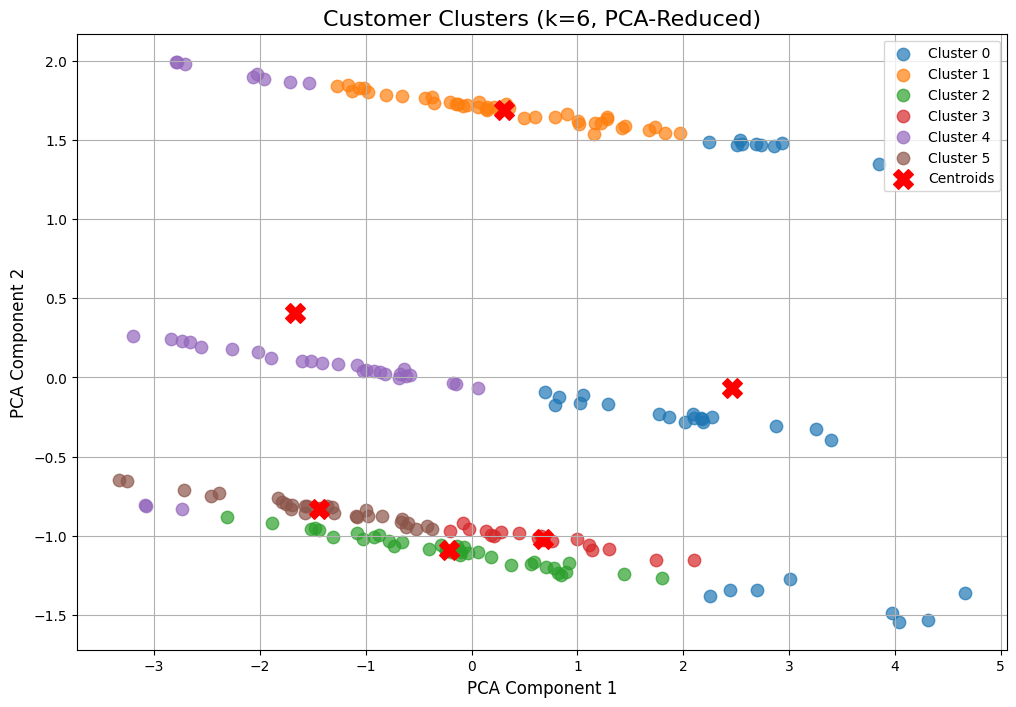

In [16]:
# Scatter plot for clusters
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(customer_data['Cluster'])

# Plot each cluster with different colors
for cluster in unique_clusters:
    cluster_points = reduced_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                label=f'Cluster {cluster}', s=80, alpha=0.7)

# Add cluster centers
if hasattr(kmeans_optimal, 'cluster_centers_'):
    cluster_centers_pca = pca.transform(kmeans_optimal.cluster_centers_)
    plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
                c='red', s=200, marker='X', label='Centroids')

# Add title, labels, and legend
plt.title('Customer Clusters (k=6, PCA-Reduced)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
